# Relax Data Science Challenge
## Loading the Libraries and the Data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('takehome_users.csv', encoding='latin-1')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
ses = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')
ses.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
ses['user_id'].drop_duplicates().shape

(8823,)

## Data Wrangling

In [5]:
ses['time_stamp'] = pd.to_datetime(ses['time_stamp']) - pd.to_timedelta(7, unit='d')

In [6]:
ses_stats = pd.Series([])

In [7]:
days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
for day in days:
    k = ses.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W-' + day)])['visited'].count().reset_index().sort_values('user_id')
    k = k.groupby('user_id')['visited'].max()
    if len(ses_stats) == 0:
        ses_stats = k
    else:
        ses_stats = pd.DataFrame([ses_stats, k]).max()

In [8]:
ses_stats.head()

user_id
1    1
2    3
3    1
4    1
5    1
dtype: int64

In [9]:
df['adopted_user'] = df['object_id'].apply(lambda x: 1 if x in ses_stats and ses_stats[x] >= 3 else 0)

In [10]:
df['adopted_user'].value_counts()

0    10398
1     1602
Name: adopted_user, dtype: int64

In [11]:
invited_users = df[df['invited_by_user_id'].notnull()]['invited_by_user_id'].astype('int')
invited_users = pd.Series(1, index=invited_users)

## EDA

C:\Users\kirti\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


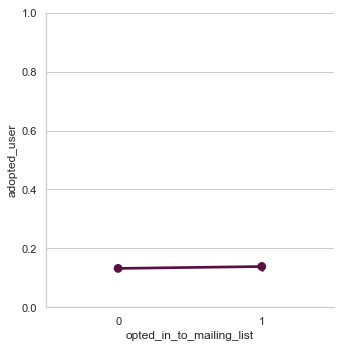

In [12]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=df, x_vars=['opted_in_to_mailing_list'], y_vars='adopted_user', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

We see that there is a negligible difference between the two classes. This implies that customers who opted in to mailing list has very little to do with if they ended up being an adopted user.

C:\Users\kirti\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


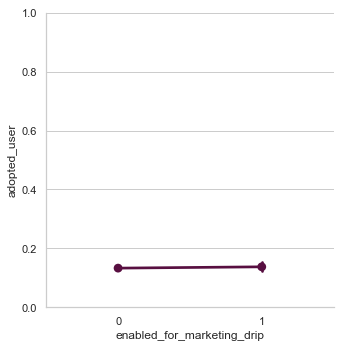

In [13]:
g = sns.PairGrid(data=df, x_vars=['enabled_for_marketing_drip'], y_vars='adopted_user', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

We obtain extremely similar results as above. Unfortunately, the Marketing Drip feature also isn't too helpful in identifying adopted users.

C:\Users\kirti\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


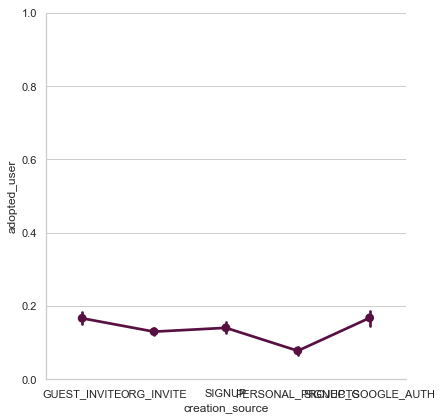

In [14]:
g = sns.PairGrid(data=df, x_vars=['creation_source'], y_vars='adopted_user', size=6)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

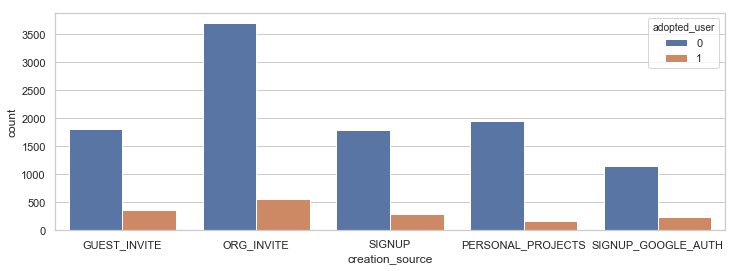

In [15]:
plt.figure(figsize=(12,4))
sns.countplot(x='creation_source', data=df, hue='adopted_user')

People with **Personal Projects** are extremely less likely to be an adopted user as compared to other creation source methods. But since this does not help us in identifying adopted users, this too, isn't a very useful feature.

In [16]:
df['invited'] = df['object_id'].apply(lambda x: 1 if x in invited_users else 0)

C:\Users\kirti\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


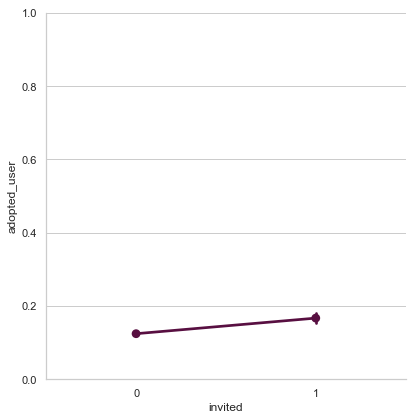

In [17]:
g = sns.PairGrid(data=df, x_vars=['invited'], y_vars='adopted_user', size=6)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

People who have invited other users have a slightly larger chance of being an adopted user.

In [18]:
def stacked_bar(feature):
    ctab = pd.crosstab([df[feature]], df['adopted_user'], dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab.plot(kind='bar', stacked=True, legend=False)

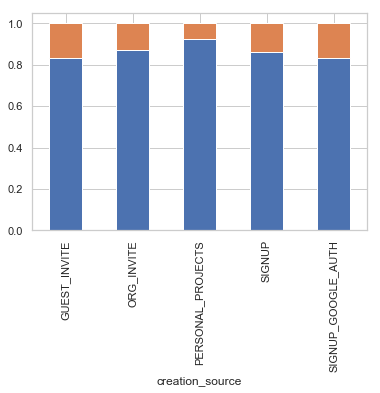

In [19]:
stacked_bar('creation_source')

In [20]:
df['email'] = df['email'].apply(lambda x: x[x.find('@')+1:])
major_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
df['email'] = df['email'].apply(lambda x: 'other' if x not in major_domains else x[:x.find('.')])

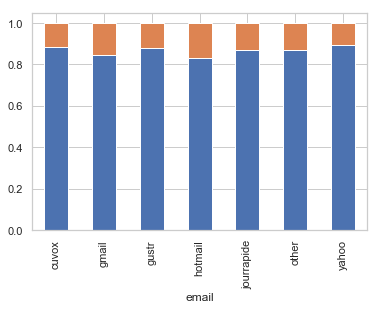

In [21]:
stacked_bar('email')

People who have signed up using **hotmail** are most likely to become adopted users whereas people with **yahoo** IDs are the least likely. However, since the difference is so small, it might be entirely possible that these observations are due to noise.

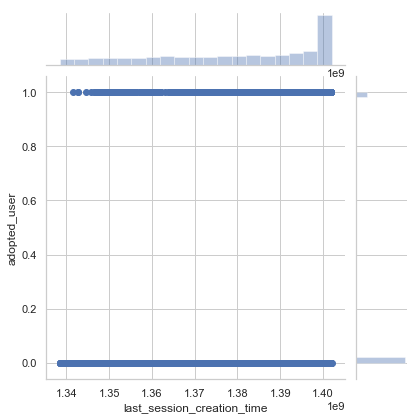

In [22]:
sns.jointplot(x='last_session_creation_time', y='adopted_user', data=df)

There seems to be a medium correlation between the last session creation time and the target variable. This may be the most important feature to predcit our adopted users as all the other variables have been extremely weak in explaining the target variable.

## Feature Engineering

In [23]:
df = df.set_index('object_id')

In [24]:
df = df.drop('name', axis=1)

In [25]:
df['email'].value_counts().head(10)

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64

In [26]:
df = df.drop('invited_by_user_id', axis=1)

In [27]:
df['org_id'].value_counts().shape

(417,)

In [28]:
df[df['adopted_user'] == 1]['org_id'].value_counts().shape

(400,)

In [29]:
df = df.drop('org_id', axis=1)

In [30]:
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['month'] = df['creation_time'].apply(lambda x: x.month)
df['year'] = df['creation_time'].apply(lambda x: x.year)

In [31]:
df = df.drop('creation_time', axis=1)

In [32]:
df['year'] = df['year'].astype('str')
df['month'] = df['month'].astype('str')

In [33]:
df = pd.get_dummies(df, prefix='is')

In [34]:
#df = df.drop('last_session_creation_time', axis=1)
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(df['last_session_creation_time'].mean())

## Machine Learning

In [35]:
X, y = df.drop('adopted_user', axis=1), df['adopted_user']

In [36]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.85, test_size=0.15, stratify=y)

In [37]:
classifier = GradientBoostingClassifier(verbose=True)
classifier.fit(train_X, train_y)
classifier.score(test_X, test_y)

      Iter       Train Loss   Remaining Time 
         1           0.6593            1.88s
         2           0.5916            1.76s
         3           0.5439            1.75s
         4           0.5068            1.68s
         5           0.4773            1.65s
         6           0.4533            1.61s
         7           0.4307            1.57s
         8           0.4134            1.52s
         9           0.3985            1.49s
        10           0.3809            1.47s
        20           0.3044            1.48s
        30           0.2729            1.16s
        40           0.2353            0.93s
        50           0.2141            0.75s
        60           0.2007            0.60s
        70           0.1897            0.47s
        80           0.1802            0.31s
        90           0.1732            0.15s
       100           0.1670            0.00s


0.9688888888888889

In [38]:
confusion_matrix(test_y, classifier.predict(test_X))

array([[1545,   15],
       [  41,  199]], dtype=int64)

In [39]:
classifier.feature_importances_.shape

(31,)

In [40]:
features = pd.Series(classifier.feature_importances_, index=X.columns)

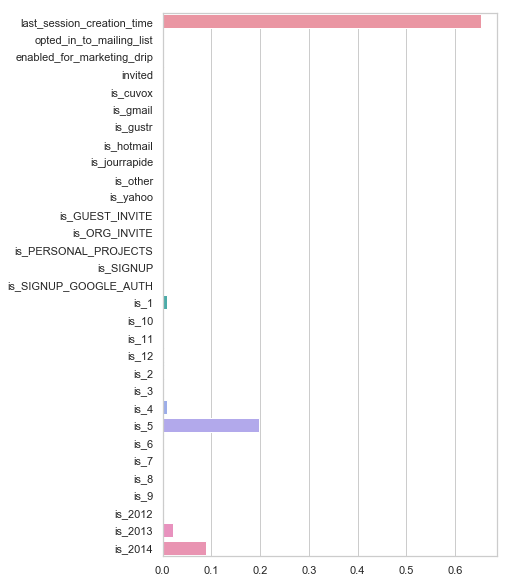

In [41]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=classifier.feature_importances_)

## Conclusion

From the analysis and the predictive modeling that we have performed above, the results can be summarized as follows:

* **86%** of our userbase are non adopted users. This clearly indicates that there is a lot that can be done to decrease this proportion relative to the number of adopted users.
* **last_session_creation_time** is the most important feature when it comes to predicting adopted users. It accounts for more than 68% of the importance in our Gradient Boosting Classifier.
* **Year and Month** of account created is the next most important information. However, its importance is negligible compared to last login time.
* All the other features have close to zero importance and do not explain the target variable well. 